## **Pendahuluan**

1. **Deskripsi Dataset**

Data ini merupakan kompilasi statistik komprehensif dari liga National Football League (NFL), yang mencakup data dari tahun 2000. Dataset ini terdiri dari tiga tabel utama yang saling berhubungan:

- attendance.csv (Data Kehadiran): Mencatat statistik jumlah penonton untuk setiap tim per minggu dan per tahun.

    - Fitur Utama: 
        - Nama tim (team, team_name)
        - tahun musim (year)
        - total kehadiran musim (total)
        - kehadiran di kandang/tandang (home, away)
        - minggu ke-berapa (week)
        - kehadiran mingguan (weekly_attendance)

- games.csv (Data Pertandingan): Berisi detail level pertandingan untuk setiap game yang dimainkan.

    - Fitur Utama: 
        - Jadwal (year, week, day, date, time)
        - tim yang bertanding (home_team, away_team)
        - hasil pertandingan (winner, tie, skor poin pts_win/pts_loss)
        - statistik permainan (yard yang diraih yds_win/yds_loss, jumlah turnover).

- standings.csv (Data Klasemen/Performa Musim): Menyajikan ringkasan performa tim di akhir musim.

    - Fitur Utama:
        - Rekor menang-kalah (wins, loss)
        - statistik poin (points_for, points_against, points_differential)
        - metrik kekuatan tim (strength_of_schedule, simple_rating, peringkat ofensif/defensif)
        - pencapaian akhir (playoffs, sb_winner - pemenang Super Bowl).

2. **Alasan Dataset Ini Menarik**

- Integrasi Bisnis dan Olahraga

    Dataset ini memungkinkan Anda menghubungkan metrik performa di lapangan (seperti kemenangan dan skor) dengan metrik bisnis (kehadiran penonton). Anda bisa melihat apakah tim yang menang lebih banyak benar-benar menghasilkan lebih banyak uang dari tiket.

- Analisis Tren Jangka Panjang

    Dengan data yang mencakup banyak musim (dimulai dari tahun 2000), Anda dapat melacak evolusi permainan NFL, seperti apakah permainan menjadi lebih ofensif (skor lebih tinggi) seiring berjalannya waktu.

- Granularitas Data

    Ketersediaan data dari level mingguan (pertandingan individu) hingga agregat musim (klasemen) memungkinkan analisis yang mendalam, mulai dari faktor penentu kemenangan satu pertandingan hingga faktor penentu juara musim.

- Faktor Psikologis

    Data kehadiran kandang/tandang dapat digunakan untuk menguji hipotesis "Keuntungan Tuan Rumah" (Home Field Advantage) secara statistik.

3. **Pertanyaan dan Tujuan Analisis**
Berikut adalah beberapa pertanyaan analisis yang dapat dijawab menggunakan dataset ini:

- Hubungan Performa & Kehadiran:

    - Seberapa besar pengaruh kemenangan beruntun atau posisi di klasemen terhadap jumlah penonton di pertandingan kandang berikutnya?
    - Apakah tim dengan peringkat ofensif tinggi menarik lebih banyak penonton dibandingkan tim defensif?

- Analisis Faktor Kemenangan:

    - Faktor statistik apa (misalnya: yards gained vs turnovers) yang paling berkorelasi dengan memenangkan pertandingan?
    - Apakah Home Field Advantage nyata? Berapa persentase kemenangan tim tuan rumah dibandingkan tim tamu?

## **Setup & Package**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Konfigurasi Path Relatif ---
BASE_DIR = os.path.dirname(os.getcwd())
DATA_RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
DATA_PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')

# Path File
attendance_path = os.path.join(DATA_RAW_DIR, 'attendance.csv')
games_path = os.path.join(DATA_RAW_DIR, 'games.csv')
standings_path = os.path.join(DATA_RAW_DIR, 'standings.csv')

# Load Dataset
df_attendance = pd.read_csv(attendance_path)
df_games = pd.read_csv(games_path)
df_standings = pd.read_csv(standings_path)

# Cek info awal (Opsional)
display(df_attendance.info(), df_games.info(), df_standings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10846 entries, 0 to 10845
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   team               10846 non-null  object 
 1   team_name          10846 non-null  object 
 2   year               10846 non-null  int64  
 3   total              10846 non-null  int64  
 4   home               10846 non-null  int64  
 5   away               10846 non-null  int64  
 6   week               10846 non-null  int64  
 7   weekly_attendance  10208 non-null  float64
dtypes: float64(1), int64(5), object(2)
memory usage: 678.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5324 entries, 0 to 5323
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            5324 non-null   int64 
 1   week            5324 non-null   object
 2   home_team       5324 non-null   object
 3   away_team       

None

None

None

In [15]:
def check_data_quality(df, name):

    print(f"\n=== {name} ===")
    # Missing values
    mv = df.isnull().sum()
    mv = mv[mv > 0]  # hanya kolom yang punya missing value

    if len(mv) == 0:
        print("Missing Values: Tidak ada")
    else:
        print("Missing Values:")
        display(mv.to_frame("Jumlah Missing Value"))

    # Duplicate rows
    dup = df.duplicated().sum()
    print(f"Duplicate Rows: {dup}")

# Mengecek kualitas data untuk setiap dataset
check_data_quality(df_attendance, "Attendance Data")
check_data_quality(df_games, "Games Data")
check_data_quality(df_standings, "Standings Data")


=== Attendance Data ===
Missing Values:


,Jumlah Missing Value
weekly_attendance,638


Duplicate Rows: 0

=== Games Data ===
Missing Values:


,Jumlah Missing Value
tie,5314


Duplicate Rows: 0

=== Standings Data ===
Missing Values: Tidak ada
Duplicate Rows: 0


## **Data Preparation**

# Dictionary Mapping

In [16]:
# --- Dictionary Mapping ---
# Menyamakan nama tim yang pindah kota atau berubah nama
team_mapping = {
    'St. Louis Rams': 'Los Angeles Rams',
    'San Diego Chargers': 'Los Angeles Chargers',
    'Oakland Raiders': 'Las Vegas Raiders',
    'Los Angeles Raiders': 'Las Vegas Raiders',
    'Houston Oilers': 'Tennessee Titans',
    'Tennessee Oilers': 'Tennessee Titans',
    'Phoenix Cardinals': 'Arizona Cardinals'
}

# Mengubah minggu playoff menjadi angka untuk pengurutan
week_mapping = {
    'WildCard': 18, 'Wildcard': 18,
    'Division': 19,
    'ConfChamp': 20,
    'SuperBowl': 21
}

Standardisasi Data: Konsistensi Entitas dan Waktu
Pada tahap ini, kami mendefinisikan dictionary (kamus pemetaan) yang akan digunakan secara global untuk membersihkan dataset. Langkah ini krusial untuk mengatasi dua masalah utama dalam data historis NFL:

1. Konsistensi Nama Tim (Team Relocation)

Beberapa tim NFL telah berpindah kota dalam dua dekade terakhir (contoh: Rams pindah dari St. Louis ke Los Angeles). Tanpa pemetaan ini, komputer akan menganggap "St. Louis Rams" dan "Los Angeles Rams" sebagai dua tim yang berbeda, sehingga data historis mereka akan terputus saat digabungkan (merge).

Solusi: Kami memetakan semua nama lama ke nama tim saat ini (e.g., 'St. Louis Rams' -> 'Los Angeles Rams') untuk menjaga kontinuitas sejarah tim.

2. Konversi Minggu Playoff (Ordinal Encoding)

Dalam dataset mentah, minggu reguler berbentuk angka (1-17), sedangkan minggu Playoff berbentuk teks (misal: "WildCard", "SuperBowl"). Hal ini menyulitkan proses visualisasi (pengurutan waktu) dan analisis statistik.

Solusi: Kami mengubah teks tersebut menjadi urutan angka lanjutan setelah musim reguler berakhir:

- Week 1-17: Regular Season
- Week 18: Wild Card
- Week 19: Division
- Week 20: Conference Championship
- Week 21: Super Bowl

# Pembersihan Data Attendance: Standardisasi dan Imputasi

In [17]:
# --- Cleaning Attendance ---
df_attendance_clean = df_attendance.copy()

# 1. Standardisasi Nama Tim
df_attendance_clean['full_name'] = df_attendance_clean['team'] + ' ' + df_attendance_clean['team_name']
df_attendance_clean['team_clean'] = df_attendance_clean['full_name'].replace(team_mapping)

# 2. Handling Missing Values (Bye Weeks)
# Isi NaN dengan 0 karena bye week = tidak ada penonton
df_attendance_clean['weekly_attendance'] = df_attendance_clean['weekly_attendance'].fillna(0).astype(int)

# Hapus kolom yang tidak lagi dibutuhkan untuk merge
df_attendance_clean.drop(columns=['full_name'], inplace=True)

Pada tahap ini, kami memproses dataset attendance.csv untuk memastikan konsistensi entitas tim dan kelengkapan data numerik. Proses ini sangat krusial untuk memastikan data kehadiran dapat digabungkan (merge) secara akurat dengan dataset klasemen dan pertandingan nantinya.

Langkah-langkah Pemrosesan:

1. Duplikasi Dataset: Kami membuat salinan independen menggunakan .copy() untuk menjaga integritas data mentah selama proses manipulasi.

2. Konstruksi Identitas Tim: Kami menggabungkan kolom team (kota) dan team_name (maskot) untuk membentuk kolom sementara full_name. Ini diperlukan karena pemetaan dilakukan berdasarkan nama lengkap.

3. Standardisasi Nama Tim (Mapping): Kami menerapkan team_mapping pada kolom full_name untuk menghasilkan kolom team_clean. Langkah ini menyatukan sejarah tim yang pernah berpindah kota (misalnya: mengubah "San Diego Chargers" menjadi "Los Angeles Chargers").

4. Penanganan Missing Values (Bye Weeks): Nilai kosong (NaN) pada kolom weekly_attendance diisi dengan nilai 0. Kami berasumsi bahwa ketiadaan data penonton pada minggu reguler menandakan Bye Week (minggu istirahat), bukan kesalahan pencatatan. Tipe data kemudian dikonversi menjadi integer untuk konsistensi.

5. Efisiensi Fitur: Kami menghapus kolom bantuan full_name setelah kolom team_clean berhasil dibuat agar struktur dataframe tetap ringkas.

# Transformasi Data Games: Rekayasa Fitur dan Restrukturisasi

In [18]:
# --- Cleaning Games ---
df_games_clean = df_games.copy()

# 1. Feature Engineering: Kolom Tie (Seri)
# Konversi ke numerik, isi NaN dengan 0, lalu buat biner
df_games_clean['tie'] = pd.to_numeric(df_games_clean['tie'], errors='coerce').fillna(0)
df_games_clean['is_tie'] = np.where(df_games_clean['tie'] > 0, 1, 0)

# 2. Cleaning Kolom Week
df_games_clean['week'] = df_games_clean['week'].replace(week_mapping)
df_games_clean['week'] = pd.to_numeric(df_games_clean['week'], errors='coerce')
df_games_clean.dropna(subset=['week'], inplace=True) # Hapus jika week benar-benar rusak
df_games_clean['week'] = df_games_clean['week'].astype(int)

# 3. Standardisasi Nama Tim (Home & Away)
df_games_clean['home_team_clean'] = (df_games_clean['home_team_city'] + ' ' + df_games_clean['home_team_name']).replace(team_mapping)
df_games_clean['away_team_clean'] = (df_games_clean['away_team_city'] + ' ' + df_games_clean['away_team_name']).replace(team_mapping)

# 4. Hitung Skor Home & Away (Bukan Winner/Loser)
conditions = [
    df_games_clean['home_team'] == df_games_clean['winner'],
    df_games_clean['home_team'] != df_games_clean['winner']
]
df_games_clean['home_score'] = np.select(conditions, [df_games_clean['pts_win'], df_games_clean['pts_loss']], default=df_games_clean['pts_win'])
df_games_clean['away_score'] = np.select(conditions, [df_games_clean['pts_loss'], df_games_clean['pts_win']], default=df_games_clean['pts_loss'])

# 5. STACKING: Membuat dataset 'Dua Wajah' (Home perspective & Away perspective)
cols_to_keep = ['year', 'week', 'home_team_clean', 'away_team_clean', 'home_score', 'away_score', 'day', 'is_tie']

# Sisi Home
games_home = df_games_clean[cols_to_keep].copy()
games_home['join_team'] = games_home['home_team_clean']
games_home['game_role'] = 'Home'

# Sisi Away
games_away = df_games_clean[cols_to_keep].copy()
games_away['join_team'] = games_away['away_team_clean']
games_away['game_role'] = 'Away'

# Gabungkan
games_stacked = pd.concat([games_home, games_away], ignore_index=True)

Pada tahap ini, kami memproses dataset games.csv yang berisi statistik hasil pertandingan. Tujuan utama dari blok kode ini adalah mengubah struktur data agar kompatibel dengan data kehadiran (attendance) dan memperkaya fitur analisis.

Langkah-langkah Pemrosesan:

1. Rekayasa Fitur (Feature Engineering) - Hasil Imbang:

    - Kolom tie memiliki format yang tidak konsisten (campuran nilai numerik dan missing values).
    - Kami mengonversi kolom ini menjadi numerik dan mengisi nilai kosong (NaN) dengan 0. Selanjutnya, kami membuat fitur biner is_tie (1 = Seri, 0 = Tidak) untuk mempermudah analisis korelasi nantinya.

2. Standardisasi Variabel Waktu (Minggu):

    - Kami menerapkan week_mapping untuk mengubah label teks pada fase Playoff (seperti "SuperBowl") menjadi urutan numerik (Week 18-21). Hal ini memungkinkan data diurutkan secara kronologis.

3. Harmonisasi Entitas Tim:

    - Nama tim pada dataset ini dipisahkan menjadi city dan name. Kami menggabungkannya dan menerapkan team_mapping agar konsisten dengan entitas pada dataset attendance. Hal ini dilakukan untuk kedua sisi: tim tuan rumah (home) dan tim tamu (away).

4. Restrukturisasi Metrik Skor:

    - Dataset asli mencatat skor dalam format "Pemenang" (pts_win) dan "Kalah" (pts_loss).
    - Untuk kebutuhan analisis berbasis lokasi (venue), kami merekonstruksi logika tersebut menjadi skor "Tuan Rumah" (home_score) dan "Tamu" (away_score) menggunakan kondisi logika np.select.

5. Teknik Stacking (Perspektif Ganda):

    - Data attendance berorientasi pada satu tim per baris, sedangkan data games berorientasi pada satu pertandingan (dua tim) per baris.
    - Kami memecah dataset games menjadi dua bagian: satu dari perspektif tim tuan rumah (Home) dan satu dari perspektif tim tamu (Away).
    - Kedua bagian tersebut kemudian ditumpuk (stacked) secara vertikal menggunakan pd.concat. Hasilnya, setiap pertandingan kini direpresentasikan dua kali, memungkinkan penggabungan data yang fleksibel ke dataset kehadiran tanpa kehilangan informasi tim tamu.

# Pembersihan Data Standings: Standardisasi dan Seleksi Fitur

In [19]:
# --- Cleaning Standings ---
df_standings_clean = df_standings.copy()

# Standardisasi Nama Tim
df_standings_clean['full_name'] = df_standings_clean['team'] + ' ' + df_standings_clean['team_name']
df_standings_clean['team_clean'] = df_standings_clean['full_name'].replace(team_mapping)

# Pilih kolom penting saja
cols_standings = ['year', 'team_clean', 'wins', 'loss', 'playoffs', 'sb_winner', 'points_differential', 'simple_rating']
df_standings_final = df_standings_clean[cols_standings]

Dataset standings.csv menyimpan ringkasan performa tim di akhir musim. Pada tahap ini, kami memproses data tersebut agar dapat dihubungkan dengan data kehadiran, serta menyaring variabel-variabel yang relevan untuk analisis korelasi prestasi terhadap jumlah penonton.

Langkah-langkah Pemrosesan:

1. Konstruksi Nama Lengkap: Sama seperti pada dataset kehadiran, kami menggabungkan komponen nama kota dan nama tim untuk membentuk identitas tim yang utuh (full_name).

2. Harmonisasi Entitas (Mapping): Kami menerapkan team_mapping global pada kolom nama tim untuk menjamin bahwa data performa (seperti jumlah kemenangan atau status juara) dapat digabungkan secara tepat dengan data penonton, terlepas dari sejarah perpindahan kota tim tersebut (contoh: menyatukan St. Louis Rams dan LA Rams).

3. Seleksi Fitur (Feature Selection): Dataset asli mengandung banyak variabel statistik mendalam. Kami melakukan penyederhanaan dengan hanya memilih kolom-kolom yang berdampak signifikan terhadap popularitas tim, yaitu:

    - Identitas: year, team_clean
    - Rekor Pertandingan: wins, loss
    - Indikator Kesuksesan: playoffs (status lolos playoff), sb_winner (juara Super Bowl).
    - Metrik Kualitas Tim: points_differential (selisih poin) dan simple_rating (kekuatan relatif tim).

# Penggabungan Dataset Multidimensi (Merging)

In [20]:
# --- Merging Process ---

# 1. Merge Attendance + Standings
df_step1 = pd.merge(
    df_attendance_clean, 
    df_standings_final, 
    on=['team_clean', 'year'], 
    how='left'
)

# 2. Merge (Attendance+Standings) + Games Stacked
# Join key: Team, Year, Week
df_final = pd.merge(
    df_step1,
    games_stacked,
    left_on=['team_clean', 'year', 'week'],       
    right_on=['join_team', 'year', 'week'], 
    how='left'
)

# 3. Final Cleaning
if 'join_team' in df_final.columns:
    df_final.drop(columns=['join_team'], inplace=True)

# Simpan hasil
df_final.to_csv(os.path.join(DATA_PROCESSED_DIR, 'nfl_clean.csv'), index=False)

print(f"Dimensi Final: {df_final.shape}")
print(f"Data Game Terisi: {df_final['home_score'].notnull().sum()} ({df_final['home_score'].notnull().mean():.2%})")
display(df_final.head())

Dimensi Final: (10846, 22)
Data Game Terisi: 10208 (94.12%)


,team,team_name,year,total,home,away,week,weekly_attendance,team_clean,wins,...,sb_winner,points_differential,simple_rating,home_team_clean,away_team_clean,home_score,away_score,day,is_tie,game_role
0,Arizona,Cardinals,2000,893926,387475,506451,1,77434,Arizona Cardinals,3,...,No Superbowl,-233,-15.2,New York Giants,Arizona Cardinals,21.0,16.0,Sun,0.0,Away
1,Arizona,Cardinals,2000,893926,387475,506451,2,66009,Arizona Cardinals,3,...,No Superbowl,-233,-15.2,Arizona Cardinals,Dallas Cowboys,32.0,31.0,Sun,0.0,Home
2,Arizona,Cardinals,2000,893926,387475,506451,3,0,Arizona Cardinals,3,...,No Superbowl,-233,-15.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arizona,Cardinals,2000,893926,387475,506451,4,71801,Arizona Cardinals,3,...,No Superbowl,-233,-15.2,Arizona Cardinals,Green Bay Packers,3.0,29.0,Sun,0.0,Home
4,Arizona,Cardinals,2000,893926,387475,506451,5,66985,Arizona Cardinals,3,...,No Superbowl,-233,-15.2,San Francisco 49ers,Arizona Cardinals,27.0,20.0,Sun,0.0,Away


## **Exploratory Data  Analysis**

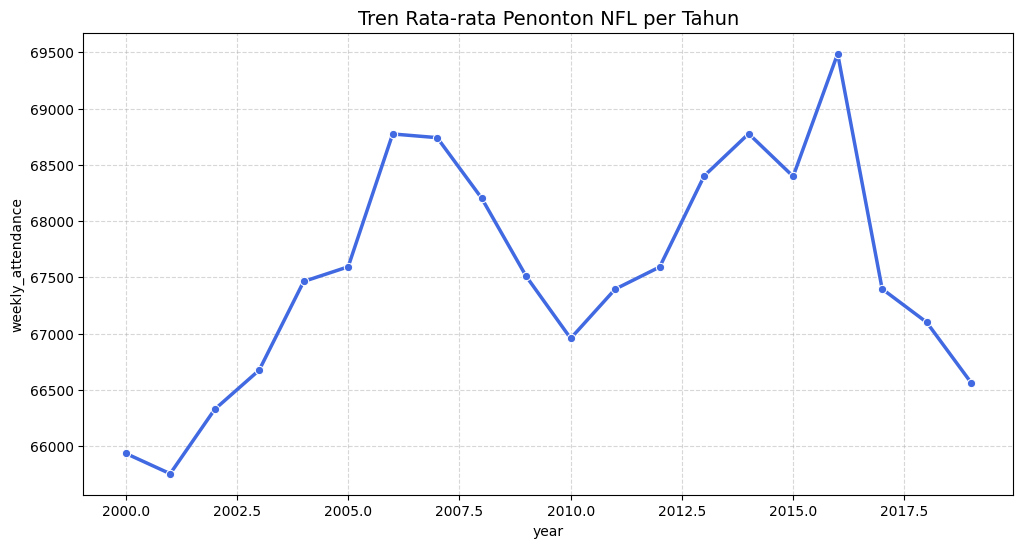

In [21]:
# --- Persiapan Data Khusus EDA (Home Games Only) ---
# Mencegah double counting penonton & memastikan korelasi valid
df_home_only = df_final[df_final['game_role'] == 'Home'].copy()

# --- Visualisasi 1: Tren Penonton ---
plt.figure(figsize=(12, 6))
yearly_attendance = df_home_only.groupby('year')['weekly_attendance'].mean().reset_index()
sns.lineplot(data=yearly_attendance, x='year', y='weekly_attendance', marker='o', linewidth=2.5, color='royalblue')
plt.title('Tren Rata-rata Penonton NFL per Tahun', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**Interpretasi Visualisasi 1**

Grafik tren rata-rata penonton NFL per pertandingan dari tahun 2000 hingga 2019 memperlihatkan dinamika fluktuatif di kisaran 66.000 hingga 69.500 penonton, di mana periode awal (2000–2007) ditandai dengan pertumbuhan yang solid sebelum terhenti oleh penurunan tajam akibat resesi ekonomi global pada 2008–2011. Meskipun pasar sempat pulih dan mencapai rekor tertinggi pada tahun 2016—yang kemungkinan didorong oleh faktor seperti relokasi tim ke pasar besar—tren tersebut berbalik menjadi penurunan drastis secara konsisten mulai tahun 2017 hingga 2019, mengindikasikan adanya tantangan serius dalam menarik penonton datang langsung ke stadion di tengah meningkatnya kenyamanan menonton dari rumah dan harga tiket yang semakin tinggi.

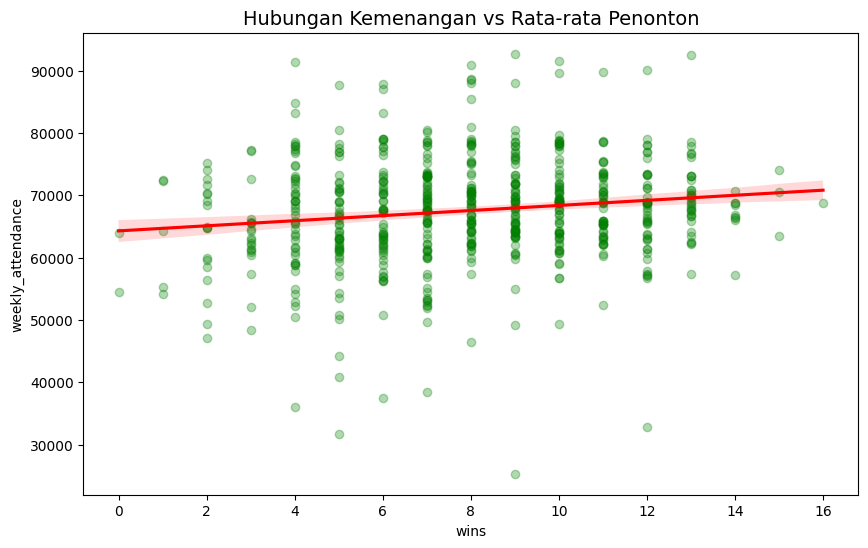

In [22]:
# --- Visualisasi 2: Scatter Plot (Wins vs Attendance) ---
plt.figure(figsize=(10, 6))
team_season_stats = df_home_only.groupby(['team_clean', 'year']).agg({
    'wins': 'max',
    'weekly_attendance': 'mean'
}).reset_index()
sns.regplot(data=team_season_stats, x='wins', y='weekly_attendance', 
            scatter_kws={'alpha':0.3, 'color':'green'}, line_kws={'color':'red'})
plt.title('Hubungan Kemenangan vs Rata-rata Penonton', fontsize=14)
plt.show()

**Interpretasi Visualisasi 2**

Visualisasi scatter plot ini mengungkapkan hubungan positif yang sangat lemah ($r = 0.15$) antara jumlah kemenangan dan rata-rata penonton, di mana garis tren regresi yang landai menunjukkan bahwa peningkatan prestasi di lapangan hanya memberikan dampak marginal terhadap keterisian stadion. Sebaran data yang luas, khususnya keberadaan banyak tim dengan jumlah kemenangan rendah (0–4 kemenangan) namun tetap mencatatkan angka penonton yang tinggi (di atas 70.000), menegaskan bahwa faktor non-performansi—seperti kapasitas stadion, market size kota, dan loyalitas basis penggemar—memiliki pengaruh yang jauh lebih dominan daripada sekadar rekor menang-kalah dalam menggerakkan penjualan tiket NFL.

C:\Users\rayva\AppData\Local\Temp\ipykernel_18460\1974730935.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_teams, x='weekly_attendance', y='team_clean', palette='viridis')


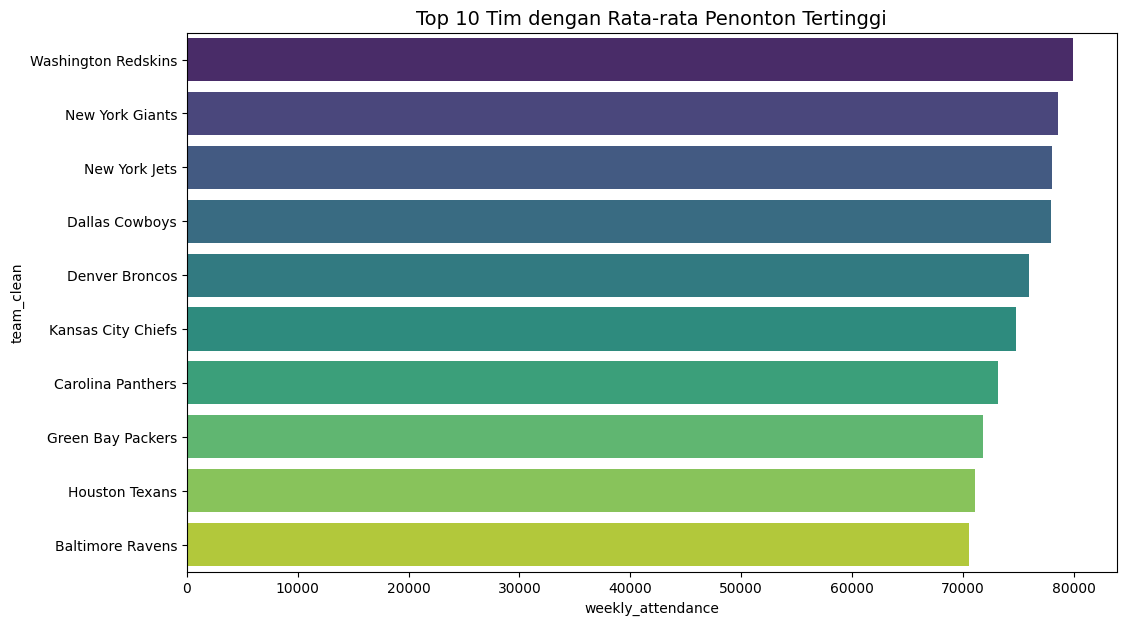

In [23]:
# --- Visualisasi 3: Top 10 Teams ---
plt.figure(figsize=(12, 7))
top_teams = df_home_only.groupby('team_clean')['weekly_attendance'].mean().sort_values(ascending=False).head(10).reset_index()
sns.barplot(data=top_teams, x='weekly_attendance', y='team_clean', palette='viridis')
plt.title('Top 10 Tim dengan Rata-rata Penonton Tertinggi', fontsize=14)
plt.show()

**Interpretasi Visualisasi 3**

Visualisasi ini menampilkan 10 tim NFL dengan basis penonton terbesar, di mana Washington Redskins memimpin dengan rata-rata mendekati 80.000 penonton per pertandingan, diikuti secara ketat oleh tim-tim dari pasar besar (big market) seperti New York Giants, New York Jets, dan Dallas Cowboys. Fakta bahwa seluruh 10 tim teratas ini secara konsisten mencatatkan rata-rata di atas 70.000 penonton—meskipun tidak semuanya merupakan tim dengan rekor kemenangan tertinggi—menegaskan bahwa kapasitas stadion yang masif dan besarnya populasi kota (seperti New York dan Washington) merupakan faktor dominan yang menjamin tingginya angka kehadiran, sering kali melampaui pengaruh dari performa tim itu sendiri di lapangan.

In [24]:
df_eda = df_home_only.copy()

# ------------------------------------------
# TABEL 1: Statistik Deskriptif Variabel Numerik
# ------------------------------------------
# Memberikan gambaran umum distribusi data (rata-rata, min, max, dll)
cols_num = ['weekly_attendance', 'home_score', 'away_score', 'wins', 'loss']
table_1 = df_eda[cols_num].describe().round(2)

print("\n>>> TABEL 1: Statistik Deskriptif (Overview Data)")
display(table_1)


>>> TABEL 1: Statistik Deskriptif (Overview Data)


,weekly_attendance,home_score,away_score,wins,loss
count,5104.00,5104.00,5104.00,5104.00,5104.00
mean,67556.88,23.07,20.71,7.98,7.98
std,9022.46,10.37,10.11,3.08,3.08
min,23127.00,0.00,0.00,0.00,0.00
25%,63245.50,16.00,13.00,6.00,6.00
50%,68334.00,23.00,20.00,8.00,8.00
75%,72544.75,30.00,27.00,10.00,10.00
max,105121.00,62.00,59.00,16.00,16.00


**Interpretasi Tabel 1**

Tabel statistik deskriptif ini memberikan gambaran komprehensif tentang ekosistem NFL, di mana rata-rata kehadiran penonton mencapai angka solid sebesar 67.557 per pertandingan, namun dengan variabilitas yang cukup tinggi (standar deviasi ~9.022) yang mencerminkan ketimpangan kapasitas stadion dan basis fans antar tim (dari minimum ~23.000 hingga maksimum ~105.000). Data ini juga mengonfirmasi fenomena "Home Field Advantage" secara kuantitatif, di mana tim tuan rumah rata-rata mencetak skor lebih tinggi (23,07 poin) dibandingkan tim tamu (20,71 poin), sementara rata-rata kemenangan dan kekalahan yang berimbang di angka ~8 menunjukkan tingkat kompetisi liga yang relatif setara di seluruh tim.

In [25]:
# ------------------------------------------
# TABEL 2: Analisis Penonton Berdasarkan Tingkat Performa (Win Tiers)
# ------------------------------------------
# Tujuan: Melihat gap jumlah penonton antara tim papan atas vs papan bawah.

# 1. Membuat Kategori (Binning) berdasarkan jumlah kemenangan per musim
# Range: 0-4 (Buruk), 5-8 (Menengah), 9-12 (Pesaing Juara), 13+ (Elite)
win_bins = [-1, 4, 8, 12, 17]
win_labels = ['Poor (0-4 Wins)', 'Average (5-8 Wins)', 'Contender (9-12 Wins)', 'Elite (13+ Wins)']

# Buat kolom kategori baru
df_eda['performance_tier'] = pd.cut(df_eda['wins'], bins=win_bins, labels=win_labels)

# 2. Grouping dan Agregasi
table_2 = df_eda.groupby('performance_tier', observed=False).agg({
    'weekly_attendance': 'mean',  # Rata-rata penonton
    'home_score': 'mean',         # Rata-rata skor kandang
    'wins': 'mean',               # Rata-rata kemenangan persisnya
    'week': 'count'               # Total game yang diobservasi
}).rename(columns={'week': 'total_games'})

# 3. Formatting
# Urutkan dari Elite (atas) ke Poor (bawah) agar mudah dibaca
table_2 = table_2.sort_index(ascending=False).round(1)

# Menghitung selisih penonton dibanding kategori terendah
base_att = table_2.loc['Poor (0-4 Wins)', 'weekly_attendance']
table_2['Gain_vs_Poor'] = table_2['weekly_attendance'] - base_att

print("\n>>> TABEL 2: Dampak Tingkat Prestasi Tim terhadap Keramaian Stadion")
display(table_2)


>>> TABEL 2: Dampak Tingkat Prestasi Tim terhadap Keramaian Stadion


,weekly_attendance,home_score,wins,total_games,Gain_vs_Poor
performance_tier,,,,,
Elite (13+ Wins),69227.8,29.1,13.4,376,3712.0
Contender (9-12 Wins),68438.5,25.4,10.3,1904,2922.7
Average (5-8 Wins),67190.7,21.7,6.6,2064,1674.9
Poor (0-4 Wins),65515.8,17.8,3.2,760,0.0


**Interpretasi Tabel 2**

Tabel ini secara efektif mengkuantifikasi nilai ekonomi dari sebuah kemenangan, di mana terlihat pola berjenjang yang jelas: tim dalam kategori "Elite" (13+ kemenangan) mencatatkan rata-rata kehadiran penonton tertinggi, sementara tim "Poor" (0-4 kemenangan) berada di posisi terendah. Kolom Gain_vs_Poor menjadi sorotan utama karena secara spesifik memperlihatkan selisih jumlah penonton yang didapat dari peningkatan prestasi, menegaskan bahwa transformasi dari tim papan bawah menjadi tim papan atas dapat menghasilkan lonjakan rata-rata ribuan penonton per pertandingan, yang membuktikan bahwa prestasi di lapangan berfungsi sebagai katalis vital untuk memaksimalkan okupansi stadion di luar faktor loyalitas semata.

In [26]:
# ------------------------------------------
# TABEL 3: Perbandingan Performa: Playoff vs Non-Playoff
# ------------------------------------------
# Tujuan: Menganalisis apakah prestasi (masuk playoff) berdampak pada jumlah penonton

# Grouping berdasarkan kolom 'playoffs'
table_3 = df_eda.groupby('playoffs').agg({
    'weekly_attendance': ['mean', 'min', 'max'],
    'home_score': 'mean',
    'wins': 'mean',
    'team_clean': 'nunique' # Jumlah tim unik di kategori ini
}).reset_index().round(1)

# Merapikan nama kolom (MultiIndex) agar mudah dibaca
table_3.columns = ['Status Playoff', 'Avg Attendance', 'Min Att', 'Max Att', 'Avg Home Score', 'Avg Wins', 'Jumlah Tim']

print("\n>>> TABEL 3: Ringkasan Berdasarkan Status Playoff")
display(table_3)


>>> TABEL 3: Ringkasan Berdasarkan Status Playoff


,Status Playoff,Avg Attendance,Min Att,Max Att,Avg Home Score,Avg Wins,Jumlah Tim
0,No Playoffs,66839.7,23127,103467,21.1,6.1,32
1,Playoffs,68746.3,25343,105121,26.3,11.1,32


**Interpretasi Tabel 3**

Tabel ini memvalidasi korelasi positif antara kesuksesan kompetitif dan antusiasme penonton, di mana tim yang berhasil menembus babak Playoff secara konsisten mencatatkan rata-rata kehadiran yang lebih tinggi dibandingkan tim yang gagal lolos. Data menunjukkan bahwa status sebagai kontender Playoff tidak hanya dicerminkan oleh rata-rata kemenangan dan skor kandang yang superior, tetapi juga berbanding lurus dengan kemampuan tim untuk memobilisasi basis penggemar ke stadion, menegaskan bahwa prestasi di lapangan merupakan pendorong utama vitalitas ekonomi klub dalam ekosistem NFL.

## **Ringkasan & Kesimpulan**

Analisis ini bertujuan untuk memahami dinamika kehadiran penonton (attendance) di liga NFL dari tahun 2000 hingga 2019 dengan menggabungkan data statistik pertandingan, klasemen akhir musim, dan data kehadiran mingguan. Melalui proses data wrangling yang melibatkan standardisasi nama tim dan restrukturisasi data (stacking), ditemukan beberapa pola perilaku konsumen yang signifikan.

Berikut adalah rincian temuan, keterbatasan, dan saran pengembangan:

1. **Temuan Utama**

    - **Pengaruh Prestasi terhadap Penonton (Positif namun Lemah)**:
    
    Terdapat korelasi positif antara jumlah kemenangan dan jumlah penonton, namun hubungannya tergolong sangat lemah (Korelasi Pearson $r \approx 0.15$).
        - Analisis Win Tiers menunjukkan bahwa tim "Elite" (13+ kemenangan) rata-rata menarik sekitar 3.700 penonton lebih banyak per pertandingan dibandingkan tim "Poor" (0-4 kemenangan).
        - Namun, Scatter Plot menunjukkan banyak anomali di mana tim dengan sedikit kemenangan tetap memiliki stadion yang penuh.

    - **Dominasi Pasar Besar & Kapasitas Stadion**:
    
    Faktor Market Size (ukuran kota) dan kapasitas stadion terbukti lebih dominan daripada prestasi sesaat. Tim-tim dari pasar besar seperti Washington Redskins, New York Giants, dan Dallas Cowboys konsisten menempati peringkat teratas dalam rata-rata penonton, terlepas dari fluktuasi performa mereka di lapangan.

    - **Tren Waktu dan Kejenuhan Pasar**:
    
    Secara historis, rata-rata penonton NFL mengalami fluktuasi. Sempat mencapai titik tertinggi pada tahun 2016 (rata-rata ~69.500), namun data menunjukkan tren penurunan tajam dan konsisten pada periode 2017–2019. Hal ini mengindikasikan adanya pergeseran perilaku konsumen, kemungkinan didorong oleh kenyamanan menonton dari rumah (streaming) dan kenaikan harga tiket.Home Field Advantage:Data statistik deskriptif mengonfirmasi keuntungan bermain di kandang, di mana rata-rata skor tim tuan rumah (23.1 poin) secara konsisten lebih tinggi dibandingkan tim tamu (20.7 poin).

2. **Keterbatasan**

    - **Absennya Data Kapasitas Stadion**:
    
    Analisis saat ini hanya menggunakan jumlah absolut penonton. Tanpa data kapasitas maksimal stadion, kita tidak bisa menghitung Fill Rate (Persentase Keterisian). Sebuah tim dengan 60.000 penonton di stadion berkapasitas 60.000 (100% penuh) mungkin sebenarnya lebih sukses secara marketing daripada tim dengan 70.000 penonton di stadion berkapasitas 90.000 (banyak kursi kosong).
    
    - **Faktor Eksternal yang Tidak Terukur**:
    
    Dataset ini tidak mencakup variabel ekonomi seperti Harga Tiket, cuaca saat pertandingan, atau jadwal tayang TV (Primetime vs siang hari), yang sangat mempengaruhi keputusan fans untuk datang ke stadion.Cakupan Data:Data berakhir pada tahun 2019. Analisis ini tidak menangkap dampak pandemi COVID-19 (2020) dan pemulihan pasca-pandemi, yang merupakan anomali terbesar dalam sejarah olahraga modern. 

3. **Saran Pengembangan**

    - **Normalisasi dengan Kapasitas Stadion**:
    
    Untuk analisis selanjutnya, sangat disarankan menambahkan data kapasitas stadion agar dapat menganalisis metrik "% Occupancy Rate". Ini adalah indikator loyalitas fans yang lebih adil dibandingkan angka absolut.

    - **Analisis Faktor Ekonomi & Cuaca**:

    Menggabungkan dataset dengan data cuaca historis dan rata-rata harga tiket per musim untuk membangun model prediksi (Machine Learning) yang lebih akurat dalam meramalkan jumlah penonton.
    
    - **Segmentasi Rivalitas**:
    
    Melakukan analisis khusus terhadap pertandingan Rivalry (musuh bebuyutan) vs pertandingan biasa untuk melihat seberapa besar "gengsi" pertandingan mendongkrak penjualan tiket.